# Capitals with word embeddings
The objective of this small POC is to explain how you can use word embeddings in order to predict relationships between words. In this case, we will try to predict countries that correspond to certain capitals.

In natural language processing, we represent each word as a vector consisting of numbers. The vector encodes the meaning of the word. These numbers (or weights) for each word are learned using various machine learning models (like word2vec or Continous Bag of Words), which I won't cover in this small example. We will instead download the trained embeddings and use them to analyze our words.

## Downloading the word embedding from Google
Since the original Google news word embedding dataset is about 3.64 gigabytes, I've downloaded the full dataset, extracted a sample of the words that we're going to analyze in this example, and saved it in a pickle file called word_embeddings_capitals.p (included in the repo).

If you have a computer that's powerful enough to handle all this information, you can search in https://code.google.com/archive/p/word2vec/ for 'GoogleNews-vectors-negative300.bin.gz' and click the link to download the entire embedding of words. The rest of the code shown here will be useful as well.

Let's start with it:

In [23]:
# Some classic imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading the embeddings file
word_embeddings = pickle.load(open("word_embeddings_subset.p", "rb"))
print(f"Number of words in our embedding: {len(word_embeddings)}")
# There are only 243 words considered from the whole embeddings file provided by Google.
# The vector created for each word is based on all the information gathered in news.

# This is a dictionary, in where the key is the word and the value is 
# a 300th dimension vector containing the word representation
print("Shape of each vector contained in the embedding:" +
       f"{word_embeddings[next(iter(word_embeddings))].shape}")

# Print out all of the words for which we have embeddings
print(f"Words for which we have embeddings: {word_embeddings.keys()}")

Number of words in our embedding: 243
Shape of each vector contained in the embedding:(300,)
Words for which we have embeddings: dict_keys(['country', 'city', 'China', 'Iraq', 'oil', 'town', 'Canada', 'London', 'England', 'Australia', 'Japan', 'Pakistan', 'Iran', 'gas', 'happy', 'Russia', 'Afghanistan', 'France', 'Germany', 'Georgia', 'Baghdad', 'village', 'Spain', 'Italy', 'Beijing', 'Jordan', 'Paris', 'Ireland', 'Turkey', 'Egypt', 'Lebanon', 'Taiwan', 'Tokyo', 'Nigeria', 'Vietnam', 'Moscow', 'Greece', 'Indonesia', 'sad', 'Syria', 'Thailand', 'Libya', 'Zimbabwe', 'Cuba', 'Ottawa', 'Tehran', 'Sudan', 'Kenya', 'Philippines', 'Sweden', 'Poland', 'Ukraine', 'Rome', 'Venezuela', 'Switzerland', 'Berlin', 'Bangladesh', 'Portugal', 'Ghana', 'Athens', 'king', 'Madrid', 'Somalia', 'Dublin', 'Qatar', 'Chile', 'Islamabad', 'Bahrain', 'Nepal', 'Norway', 'Serbia', 'Kabul', 'continent', 'Brussels', 'Belgium', 'Uganda', 'petroleum', 'Cairo', 'Denmark', 'Austria', 'Jamaica', 'Georgetown', 'Bangkok', '

## Predicting relationship between words

Let's now write down a function to predict the relationship between words. Some details about it:
* The function will take as input three words.
* The first two are related to each other.
* It will predict a 4th word which is related to the third word in a similar manner as the two first words are related to each other.
* As an example, "Madrid is to Spain as Athens is to ______"?

Assuming that we have a vector representation of a word, how do we get vectors that are close to each other? For this, we have the Cosine Similarity and the Euclidean distance, as algebraic parameters that will us this information.

### 1) Cosine Similarity

The cosine similarity function is:

$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$

$A$ and $B$ represent the word vectors and $A_i$ or $B_i$ represent index i of that vector.
Note that if A and B are identical, you will get $cos(\theta) = 1$.
* Otherwise, if they are the total opposite, meaning, $A= -B$, then you would get $cos(\theta) = -1$.
* If you get $cos(\theta) =0$, that means that they are orthogonal (or perpendicular).
* Numbers between 0 and 1 indicate a similarity score.
* Numbers between -1-0 indicate a dissimilarity score.

In [16]:
def cosine_similarity(v1,v2):
    '''
    Input:
        v1: a numpy array which corresponds to a word vector
        v2: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    dot_product = np.dot(v1,v2)
    norm_product = np.linalg.norm(v1)*np.linalg.norm(v2)
    return dot_product/norm_product

In [24]:
# Let's try some examples
v1 = np.array([1,1,2])
v2 = np.array([1,1,2])

print(f"Cosine similarity for identical vectors: {cosine_similarity(v1,v2)}")

v2 = np.array([-1,-1,-2])

print(f"Cosine similarity for opposite vectors: {cosine_similarity(v1,v2)}")

v2 = np.array([1,-1,0])

print(f"Cosine similarity for orthogonal vectors: {cosine_similarity(v1,v2)}")


Cosine similarity for identical vectors: 1.0000000000000002
Cosine similarity for opposite vectors: -1.0000000000000002
Cosine similarity for orthogonal vectors: 0.0


If you don't want to implement this formula, there's a library that will give you the cosine distance (which is 1-cosine_similarity) right away.

In [22]:
from scipy.spatial.distance import cosine
print(f"Cosine similarity for orthogonal vectors: {1 - cosine(v1,v2)}")

Cosine similarity for orthogonal vectors: 0.0


Let's calculate the similarity between the embeddings of some of our 243 words:

In [26]:
country = word_embeddings["country"]
city = word_embeddings["city"]

queen = word_embeddings["queen"]
king = word_embeddings["king"]

print(f"Cosine similarity for 'country' and 'city': {cosine_similarity(country,city)}")
print(f"Cosine similarity for 'queen' and 'king': {cosine_similarity(queen,king)}")

Cosine similarity for 'country' and 'city': 0.3229880630970001
Cosine similarity for 'queen' and 'king': 0.6510956883430481


### 2) Euclidean distance

There's another way to compute the similarity between two vectors using the Euclidean distance.
Euclidean distance is defined as:

$$ \begin{aligned} d(\mathbf{A}, \mathbf{B})=d(\mathbf{B}, \mathbf{A}) &=\sqrt{\left(A_{1}-B_{1}\right)^{2}+\left(A_{2}-B_{2}\right)^{2}+\cdots+\left(A_{n}-B_{n}\right)^{2}} \\ &=\sqrt{\sum_{i=1}^{n}\left(A_{i}-B_{i}\right)^{2}} \end{aligned}$$

* $n$ is the number of elements in the vector
* $A$ and $B$ are the corresponding word vectors. 
* The more similar the words, the more likely the Euclidean distance will be close to 0. 

In [27]:
def euclidean_distance(v1,v2):
    '''
    Input:
        v1: a numpy array which corresponds to a word vector
        v2: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between v1 and v2.
    '''
    difference = v1 - v2
    return np.linalg.norm(difference)

In [28]:
print(f"Euclidean distance for 'country' and 'city': {euclidean_distance(country,city)}")
print(f"Euclidean distance for 'queen' and 'king': {euclidean_distance(queen,king)}")

Euclidean distance for 'country' and 'city': 2.515118360519409
Euclidean distance for 'queen' and 'king': 2.4796924591064453


### When to use Cosine Similarity?
This is a visual representation of euclidean distance (d) and cosine similarity (θ). While cosine looks at the angle between vectors (thus not taking into regard their weight or magnitude), euclidean distance is similar to using a ruler to actually measure the distance.

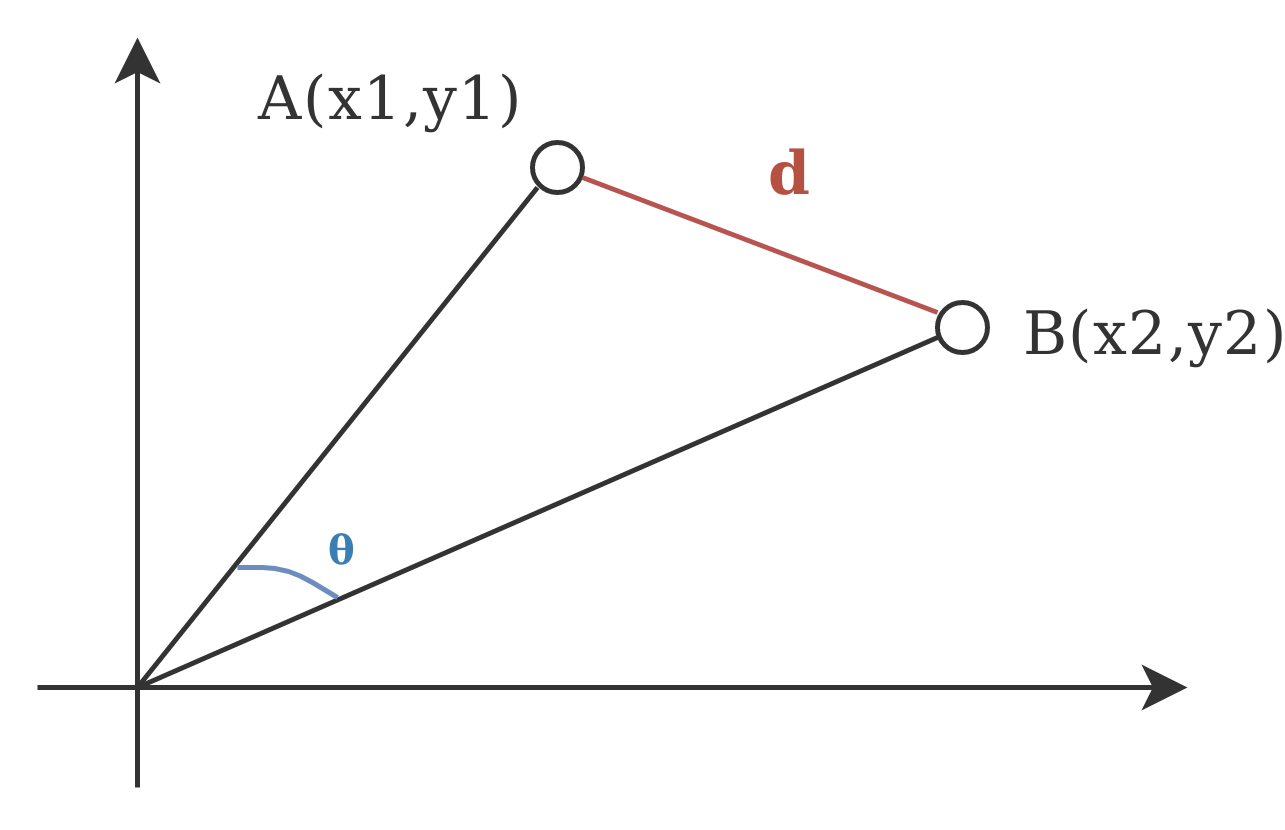

Cosine similarity is generally used as a metric for measuring distance when the magnitude of the vectors does not matter. This happens for example when working with text data represented by word counts. We could assume that when a word (e.g. science) occurs more frequent in document 1 than it does in document 2, that document 1 is more related to the topic of science. However, it could also be the case that we are working with documents of uneven lengths (Wikipedia articles for example). Then, science probably occurred more in document 1 just because it was way longer than document 2. Cosine similarity corrects for this.

Text data is the most typical example for when to use this metric. However, you might also want to apply cosine similarity for other cases where some properties of the instances make so that the weights might be larger without meaning anything different. Sensor values that were captured in various lengths (in time) between instances could be such an example.

## Finding the country for each capital
Now that we have a way to compare each of the embeddings, let's create a function that will receive three words and it will try to predict the missing country in that relationship.

For example, if it receives: Madrid, Spain and Baghdad, it should return Iraq.
As you can imagine, we will use the vector representation of these words and we can treat them mathematically to obtain what we're looking for: <b>Spain - Madrid + Baghdad = Iraq</b>

For the function we will implement, the representation that we will get about Iraq won't exactly exist in our word_embeddings dictonary. We will find the vector with the maximum cosine similarity to the one we obtain and this one will give us the country we're looking for.

In [101]:
def predict_country(city1, country1, city2, word_embeddings):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (the capital city of country2)
        word_embeddings: a dictionary where the keys are words and values are their embeddings
    Output:
        countries: a tuple with the most likely country and its similarity score
    """
    
    # In here we are basically saying: Country1 is for city1 what Country2 is for City2
    v_country2 = word_embeddings[country1] - word_embeddings[city1] + word_embeddings[city2]
    
    # The lowest bound of the cosine similarity
    max_similarity = -1
    country2 = ''
    
    for (word,vector) in word_embeddings.items():
        # Ignore words that are being used to create the vector for country2
        if word not in set((city1, country1, city2)):
            current_similarity = cosine_similarity(v_country2,vector)

            # Ignore the vector for the same city2
            if(current_similarity>max_similarity):
                max_similarity = current_similarity
                country2 = word
    
    return (country2,max_similarity)  

In [102]:
# Testing your function, note to make it more robust you can return the 5 most similar words.
a = predict_country('Athens', 'Greece', 'Cairo', word_embeddings)
print(f"Athens is for Greece what Cairo is for: {a}")

a = predict_country('Madrid', 'Spain', 'London', word_embeddings)
print(f"Madrid is for Spain what London is for: {a}")

a = predict_country('Kingston', 'Jamaica', 'Caracas', word_embeddings)
print(f"Kingston is for Jamaica what Caracas is for: {a}")

Athens is for Greece what Cairo is for: ('Egypt', 0.7626821)
Madrid is for Spain what London is for: ('England', 0.4657591)
Kingston is for Jamaica what Caracas is for: ('Venezuela', 0.7082699)


## Model Accuracy

Now we will test our new function on the dataset and check the accuracy of the model:

$$\text{Accuracy}=\frac{\text{Correct # of predictions}}{\text{Total # of predictions}}$$

For testing this, we have a file that containst the different combinations between countries and cities. It's also included in the repository (capitals.txt).

In [103]:
capitals_df = pd.read_csv("capitals.txt", sep=" ", header=None)
capitals_df.columns = ['city1', 'country1', 'city2', 'country2']
capitals_df.head()

,city1,country1,city2,country2
0,Athens,Greece,Baghdad,Iraq
1,Athens,Greece,Bangkok,Thailand
2,Athens,Greece,Beijing,China
3,Athens,Greece,Berlin,Germany
4,Athens,Greece,Bern,Switzerland


In [104]:
def get_accuracy(word_embeddings, capitals_df):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the value is its embedding
        data: a pandas dataframe containing all the country and capital city pairs
    
    Output:
        accuracy: the accuracy of the model
    '''
    
    correct_predictions = 0
    # Get the amount of rows, which is basically the total amount of predictions we'll do
    total_predictions = len(capitals_df)
    
    # We just need to iterate on the pandas dataframe and compare the results we get
    # by calling our function with the real ones
    for _,row in capitals_df.iterrows():
        # Compute the function. This returns a tuple
        predicted_country,_ = predict_country(row['city1'],row['country1'],row['city2'],word_embeddings)
        
        if predicted_country == row['country2']:
            correct_predictions += 1
        
    return correct_predictions/total_predictions

In [105]:
# Let's call the function and see what's the accuracy we get
print(f"Accuracy of our model: {get_accuracy(word_embeddings,capitals_df):.2f}")

Accuracy of our model: 0.92


## Dimensionality reduction: PCA
Now we will explore the distance between word vectors after reducing their dimension.
The technique we will employ is known as
[*principal component analysis* (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).
As we saw, we are working in a 300-dimensional space in this case.
Although from a computational perspective we were able to perform a good job,
it is impossible to visualize results in such high dimensional spaces.

You can think of PCA as a method that projects our vectors in a space of reduced
dimension (in our case 2), while keeping the maximum information about the original vectors in
their reduced counterparts. In this case, by *maximum infomation* we mean that the
Euclidean distance between the original vectors and their projected siblings is
minimal. Hence vectors that were originally close in the embeddings dictionary,
will produce lower dimensional vectors that are still close to each other.

When you map out the words, similar words will be clustered
next to each other. For example, the words 'sad', 'happy', 'joyful' all describe
emotion and are supposed to be near each other when plotted.

In this case, I won't dive much in the implementation of PCA, I will rely on scikit learn to solve this for us.

In [134]:
# This method will take the dictionary with the embeddings and the words we're looking for
# and return a matrix with all the embeddings.
def get_matrix(word_embeddings,words):
    embeddings_dimension = word_embeddings[next(iter(word_embeddings))].shape[0]
    matrix = np.zeros((len(words),embeddings_dimension))

    counter = 0
    for word in words:
        embedding = word_embeddings.get(word,np.zeros((1,embeddings_dimension)))
        matrix[counter] = embedding
        counter+=1
    
    return matrix

In [153]:
from sklearn.decomposition import PCA

# Let's take out some words from our word embedding
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']
matrix = get_matrix(word_embeddings, words)

# Implement PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(matrix)
principalDf = pd.DataFrame(data = principalComponents,columns=['PC1', 'PC2'])

# Let's add the words to every row so we can see the representation for each one of them
words_df = pd.DataFrame(words)
words_df.columns = ["Word"]
finalDf = pd.concat([principalDf, words_df], axis=1)
print(finalDf)

         PC1       PC2       Word
0   2.074031  0.226565        oil
1   1.844124  0.038569        gas
2  -1.019730  1.268881      happy
3  -1.175787  1.760764        sad
4  -0.601780 -1.093241       city
5  -0.855811 -1.296162       town
6  -0.990526 -1.612222    village
7  -0.318020 -0.415334    country
8  -0.210693 -0.575926  continent
9   2.313584  0.297835  petroleum
10 -1.059390  1.400269     joyful


In [155]:
# TO continue in the future, pending to plot this info